In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
import nltk.corpus
import re
import matplotlib.pyplot as plt
import shap
import lime

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.model_selection import train_test_split
from sklearn import neural_network
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans


tf.get_logger().setLevel('ERROR')

preprocess_url = "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4"

In [2]:
train_df = pd.read_table("2013_Queensland_Floods_train.tsv")
test_df = pd.read_table("2013_Queensland_Floods_test.tsv")
col_names = train_df.columns
train_df["text"]

0       I just though about the night I went clubbing ...
1       Looks like its going to be another long night ...
2       @LaniiBanani hahahaha I just told him id have ...
3       Off to meeting.... with so called... Baaps of ...
4                Doubt I'll be getting much sleep tonight
                              ...                        
6014    RT @GrillTeam: The Queensland government has s...
6015    Can we have 5 NEMA staff from Nigeria  come to...
6016    RT @7NewsBrisbane: Foam from rough waves at Al...
6017    RT @abcsouthqld: Master Electricians Australia...
6018    RT @HomeLoanKing: Leader of Aussie opposition,...
Name: text, Length: 6019, dtype: object

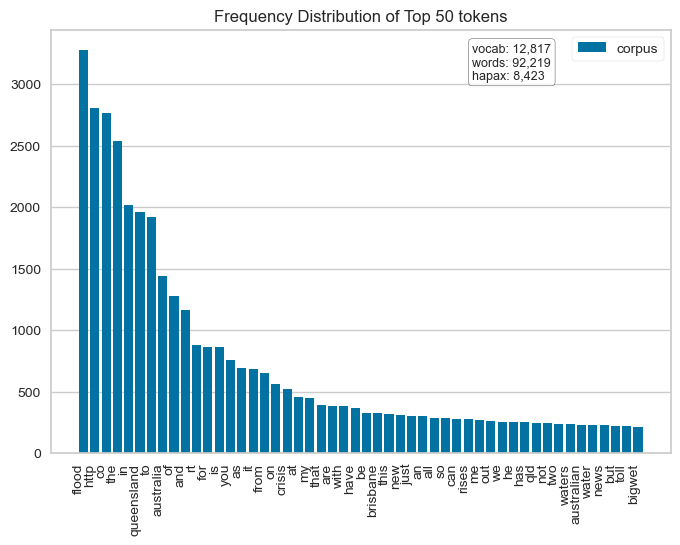

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [3]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(train_df["text"])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [4]:
from sklearn.model_selection import train_test_split

train_text = train_df["text"]
train_labels = train_df["label"]

test_text = test_df["text"]
test_labels = test_df["label"]

print(train_text.shape)
print(test_text.shape)

(6019,)
(3011,)


In [5]:
# remove digits, @-mentions, links, stopwords

train_text = train_text.str.lower()
#train_text = train_text.apply(lambda elem: re.sub(r"\d+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"@[a-zA-Z0-9-]+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
train_text = train_text.apply(lambda x : nltk.word_tokenize(x))
train_text = train_text.apply(lambda x : " ".join([word for word in x if word not in (nltk.corpus.stopwords.words() + ["rt"])]))

test_text = test_text.str.lower()
#test_text = test_text.apply(lambda elem: re.sub(r"\d+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"@[a-zA-Z0-9-]+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
test_text = test_text.apply(lambda x : nltk.word_tokenize(x))
test_text = test_text.apply(lambda x : " ".join([word for word in x if word not in (nltk.corpus.stopwords.words() + ["rt"])]))

train_text.shape

(6019,)

In [6]:
# include the hashtag anyway because #savehaiti is different from savehaiti
train_text = train_text.apply(lambda elem: re.sub(r"#", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\.", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\,", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\?", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\!", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\:", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\;", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\-", " ", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\'", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\_", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\/", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\*", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\%", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\&", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\\", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"@\s[a-zA-Z0-9]+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"@", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\$", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\[", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\]", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\~", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\(", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\)", "", elem))
train_text = train_text.apply(lambda elem: re.sub("http", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\s\s*", " ", elem))
train_text = train_text.apply(lambda elem: re.sub(r"^\s+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\s+$", "", elem))

test_text = test_text.apply(lambda elem: re.sub(r"#", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\.", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\,", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\?", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\!", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\:", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\;", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\-", " ", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\'", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\_", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\/", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\*", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\+", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\%", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\&", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\\", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"@\s[a-zA-Z0-9]+", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"@", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\$", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\[", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\]", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\~", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\(", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\)", "", elem))
test_text = test_text.apply(lambda elem: re.sub("http", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\s\s*", " ", elem))
test_text = test_text.apply(lambda elem: re.sub(r"^\s+", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\s+$", "", elem))


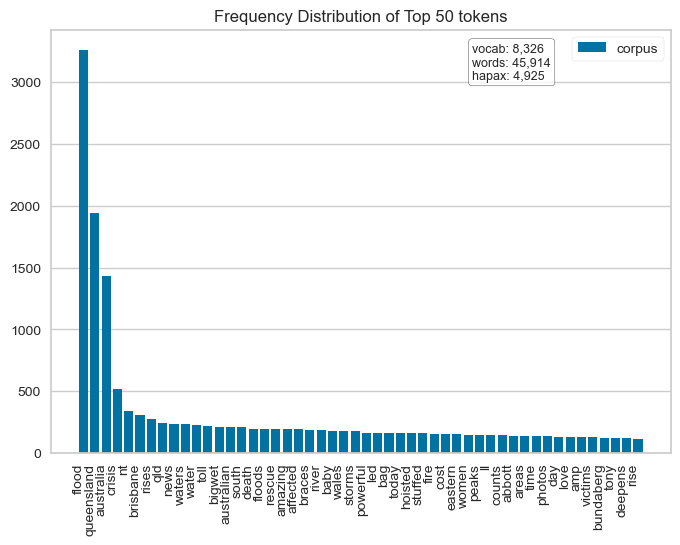

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [7]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(pd.DataFrame(train_text)["text"])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

b'not_relevant' 	 0.46037547765409537
b'relevant' 	 0.5396245223459046


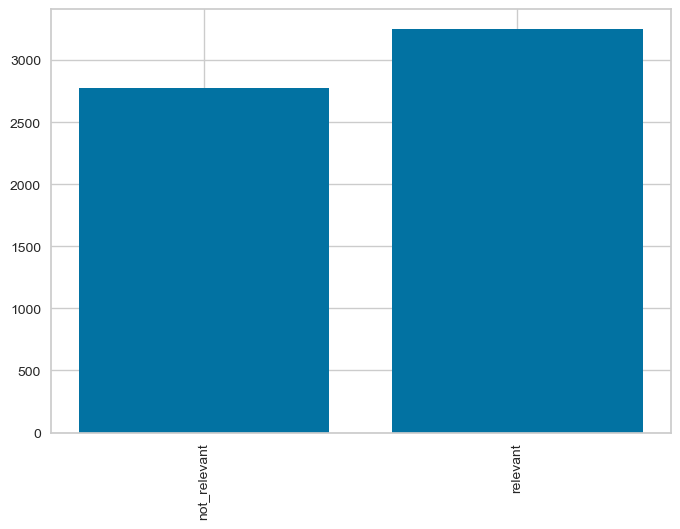

In [8]:
clean_train_df = pd.DataFrame(np.column_stack((np.array(train_text), np.array(train_labels))), columns=["text", "label"])
clean_test_df = pd.DataFrame(np.column_stack((np.array(test_text), np.array(test_labels))), columns=["text", "label"])

train_text = tf.convert_to_tensor(train_text)
train_labels = tf.convert_to_tensor(train_labels)

test_text = tf.convert_to_tensor(test_text)
test_labels = tf.convert_to_tensor(test_labels)

labels = tf.unique(train_labels)[0]
#print(np.array(tf.unique(train_labels)[1]))

for x in range(0,len(labels)):
  print(np.array(labels)[x], '\t', np.mean(x == tf.unique(train_labels)[1]))
plt.bar(np.array(labels), [np.sum(x == tf.unique(train_labels)[1]) for x in range(0,len(labels))])
plt.xticks(rotation = 90)
plt.show()

In [9]:
bert_preprocess_model = hub.KerasLayer(preprocess_url)

In [10]:
X_train, _, y_train, _ = train_test_split(np.array(train_text), np.array(train_labels), train_size=2000, shuffle=True)
preprocessed_text = bert_preprocess_model(X_train)

X_test, _, y_test, _ = train_test_split(np.array(test_text), np.array(test_labels), train_size=300, shuffle=True)
preprocessed_test_text = bert_preprocess_model(X_test)

train_text = X_train
train_labels = y_train
test_text = X_test
test_labels = y_test

preprocessed_text.keys()

dict_keys(['input_type_ids', 'input_word_ids', 'input_mask'])

In [11]:
preprocessed_test_text

{'input_type_ids': <tf.Tensor: shape=(300, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])>,
 'input_word_ids': <tf.Tensor: shape=(300, 128), dtype=int32, numpy=
 array([[  101,   188,  4003, ...,     0,     0,     0],
        [  101,   192,  1204, ...,     0,     0,     0],
        [  101, 10310,  7870, ...,     0,     0,     0],
        ...,
        [  101,  7870,  4146, ...,     0,     0,     0],
        [  101,  3404,  4204, ...,     0,     0,     0],
        [  101,   175, 22977, ...,     0,     0,     0]])>,
 'input_mask': <tf.Tensor: shape=(300, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]])>}

In [12]:
mask_lens = np.sum(preprocessed_text["input_mask"], axis=1)
mask_lens2 = np.sum(preprocessed_test_text["input_mask"], axis=1)
print(mask_lens.shape, mask_lens2.shape)
print(max(mask_lens), max(mask_lens2))

(2000,) (300,)
37 42


In [13]:
bert_model = hub.KerasLayer(encoder_url)

In [14]:
bert_results = bert_model(preprocessed_text)

bert_test_results = bert_model(preprocessed_test_text)
bert_results.keys()

dict_keys(['encoder_outputs', 'sequence_output', 'default', 'pooled_output'])

In [15]:
print("default", bert_results["default"].shape)
print("pooled_output", bert_results["pooled_output"].shape)
print("sequence_output", bert_results["sequence_output"].shape)
# these are the outputs of the 12 encoder layers: bert_results["encoder_outputs"]

default (2000, 768)
pooled_output (2000, 768)
sequence_output (2000, 128, 768)


In [16]:
sequence_output = np.array(bert_results["sequence_output"])[:2000, :41, :768]
X_train = sequence_output.reshape(X_train.shape[0], 41*768)
test_sequence_output = np.array(bert_test_results["sequence_output"])[:300, :41, :768]
X_test = test_sequence_output.reshape(X_test.shape[0], 41*768)

In [17]:
model = neural_network.MLPClassifier(hidden_layer_sizes=(32,))
model.fit(X_train, tf.unique(y_train)[1])

MLPClassifier(hidden_layer_sizes=(32,))

In [18]:
word_ids = np.array(preprocessed_text["input_word_ids"][:2000, :41])
test_word_ids = np.array(preprocessed_test_text["input_word_ids"][:300, :41])
model2 = neural_network.MLPClassifier()
model2.fit(word_ids, tf.unique(y_train)[1])

MLPClassifier()

In [19]:
print("Train accuracy:", np.mean(model.predict(X_train) == tf.unique(y_train)[1]))
print("Test accuracy:", np.mean(model.predict(X_test) == tf.unique(y_test)[1]))

print("Train accuracy:", np.mean(model2.predict(word_ids) == tf.unique(y_train)[1]))
print("Test accuracy:", np.mean(model2.predict(test_word_ids) == tf.unique(y_test)[1]))

Train accuracy: 0.999
Test accuracy: 0.056666666666666664
Train accuracy: 0.9695
Test accuracy: 0.2966666666666667


## SHAP

In [20]:
shap.initjs()
permutation_explainer = shap.explainers.Permutation(model2.predict, word_ids)
test_permutation_explainer = shap.explainers.Permutation(model2.predict, test_word_ids)

In [21]:
permutation_values = permutation_explainer(word_ids)
test_permutation_values = test_permutation_explainer(test_word_ids)

Permutation explainer: 2001it [01:36, 19.28it/s]                          
Permutation explainer: 301it [00:16,  7.18it/s]                         


In [22]:
print(permutation_values)
print(test_permutation_values)

.values =
array([[ 0.00000000e+00, -3.28571429e-02, -4.07142857e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -3.96508223e-18,  2.21428571e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.50000000e-02,  9.07142857e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00, -5.28571429e-02, -2.71428571e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.07142857e-02, -3.21428571e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.21428571e-02,  5.42857143e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

.base_values =
array([0.52, 0.52, 0.52, ..., 0.52, 0.52, 0.52])

.data =
array([[  101,  1845,  3455, ...,     0,     0,     0],
       [  101,  2302,  4458, ...,     0,     0,     0],
       [  101,  5746, 26597, ...,     0,     0,

In [23]:
print(str(train_text[0])[2:-1].split(" "))

['finished', 'reading', 'seal', 'team', 'biography', 'suggestions', 'read', 'enjoyingreadingagain']


heavy rain queensland flood strike suburbs highway closed hope ends asap qld queensland brisbane flood


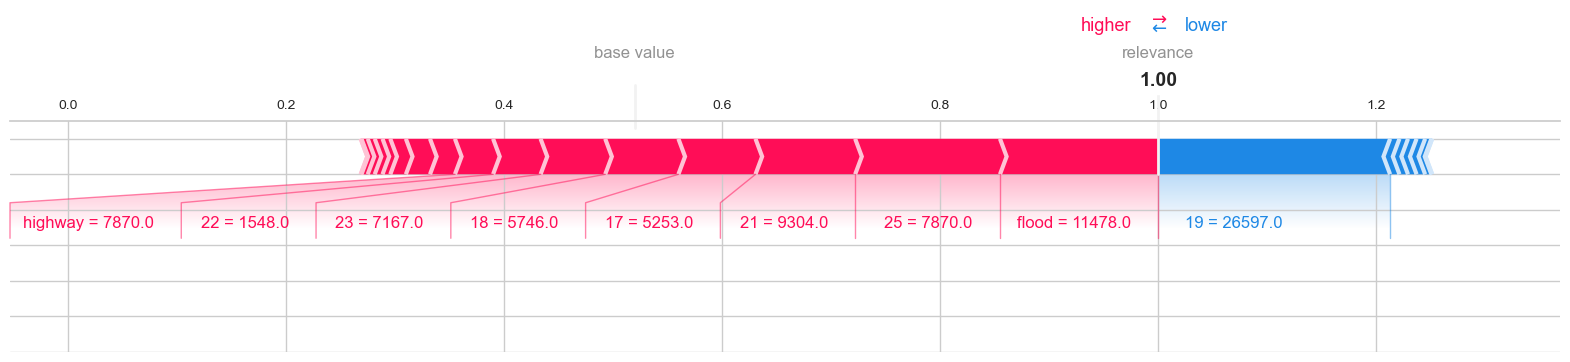

In [24]:
index = 1
print(str(train_text[index])[2:-1])
words = np.arange(1, 42).tolist()
for i in range(41):
  words[i] = str(words[i])
for (i,w) in enumerate(str(train_text[index])[2:-1].split(" ")):
  words[i] = w
shap.plots.force(permutation_values.base_values[index], permutation_values.values[index], permutation_values.data[index], feature_names=words, out_names="relevance", matplotlib=True)

wtf rain re


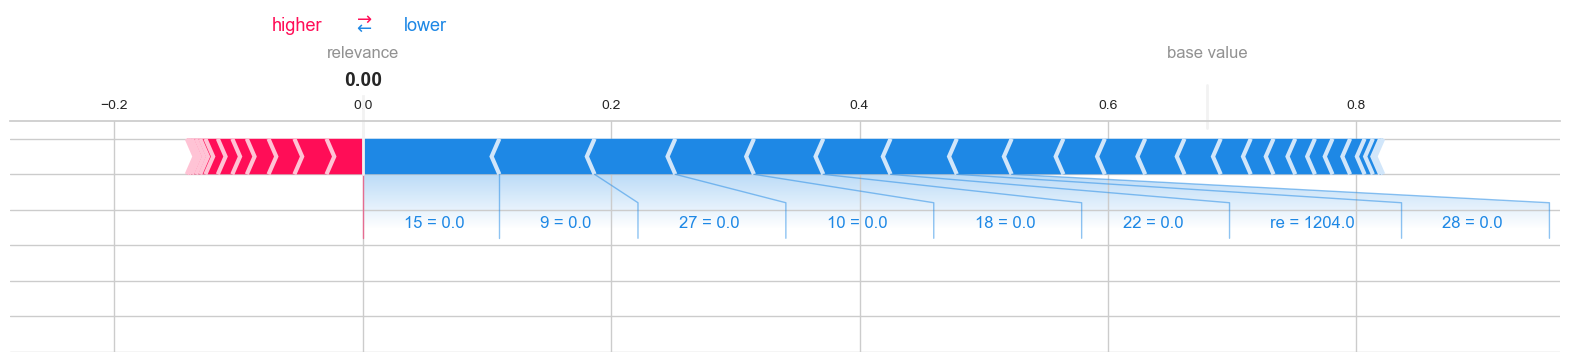

In [25]:
index = 1
print(str(test_text[index])[2:-1])
words = np.arange(1, 42).tolist()
for i in range(41):
  words[i] = str(words[i])
for (i,w) in enumerate(str(test_text[index])[2:-1].split(" ")):
  words[i] = w
shap.plots.force(test_permutation_values.base_values[index], test_permutation_values.values[index], test_permutation_values.data[index], feature_names=words, out_names="relevance", matplotlib=True)

In [ ]:
for index in range(300):
  words = np.arange(1, 42).tolist()
  for i in range(41):
    words[i] = str(words[i])
  for (i,w) in enumerate(str(test_text[index])[2:-1].split(" ")):
    words[i] = w
  print(test_text[index], test_labels[index], model2.predict(test_word_ids[index].reshape(1,-1)))
  shap.plots.force(test_permutation_values.base_values[index], test_permutation_values.values[index], test_permutation_values.data[index], feature_names=words, out_names="relevance", matplotlib=True)

In [26]:
test_text[0]

b's wave cracking video crazy motorists foam inundating streets flood ravaged queensland tcocfzqte5y'

In [62]:
from explainers.SHAP_for_text import SHAPexplainer

words_dict = {0:None}
words_dict_reverse = {None:0}

all_word_ids = np.vstack([word_ids, test_word_ids])
all_text = np.hstack([train_text, test_text])

bag_of_words = set()

for i in range(len(all_word_ids)):
  for j in range(len(all_word_ids[i])):
    if (all_word_ids[i][j+1] != 0):
      print(j, all_word_ids[i], all_text[i])
      str(all_text[i])[2:-1].split(" ")[j-1]
      word = str(all_text[i])[2:-1].split(" ")[j-1]
      bag_of_words.add(word)

for h, hh in enumerate(bag_of_words):
    words_dict[h + 1] = hh
    words_dict_reverse[hh] = h + 1

predictor = SHAPexplainer(model.predict, preprocessed_test_text, words_dict, words_dict_reverse)
train_dt = np.array([predictor.split_string(x) for x in np.array(train_text)])
print(train_text, train_dt)
idx_train_data, max_seq_len = predictor.dt_to_idx(train_dt)

explainer = shap.KernelExplainer(model=predictor.predict, data=shap.kmeans(idx_train_data, k=50))

texts_ = [predictor.split_string(x) for x in test_text]
idx_texts, _ = predictor.dt_to_idx(texts_, max_seq_len=max_seq_len)

to_use = idx_texts[-1:]
shap_values = explainer.shap_values(X=to_use, nsamples=64, l1_reg="aic")

len_ = len(texts_[-1:][0])
d = {i: sum(x > 0 for x in shap_values[i][0, :len_]) for i, x in enumerate(shap_values)}
m = max(d, key=d.get)
print(" ".join(texts_[-1:][0]))
shap.force_plot(explainer.expected_value[m], shap_values[m][0, :len_], texts_[-1:][0])


[  101  1845  3455  9438  1264  9631 17241  2373  8965 11613 28050 21347
  1179   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]
0 [  101  1845  3455  9438  1264  9631 17241  2373  8965 11613 28050 21347
  1179   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0] b'finished reading seal team biography suggestions read enjoyingreadingagain'
1 [  101  1845  3455  9438  1264  9631 17241  2373  8965 11613 28050 21347
  1179   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0] b'finished reading seal team biography suggestions read enjoyingreadingagain'
2 [  101  1845  3455  9438  1264  9631 17241  2373  8965 11613 28050 21347
  1179   102

IndexError: list index out of range

In [ ]:
print('hi')